### Notebook to compare the webform and script FONLL results

#### Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

#### Read FONLL script results from file
Each file contains the double differential cross section $\mathrm{d}^2\sigma/\mathrm{d}p_T^2\mathrm{d}y$ for each $p_T$ and $y$ value, along with the corresponding error. The format out the output is mentioned in the [`README`](https://cacciari.web.cern.ch/fonll/README) file.

In [2]:
current_path = os.getcwd()
folder_name = 'output_fonll_dsdpt_charm_5500_pdf_lha_cteq'
folder_path = current_path + '/' + folder_name

In [3]:
pt = []
y = []
sigma = []
err = []

In [4]:
for filename in os.listdir(folder_path):
    if filename.endswith('.out'):  
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            line = file.readline().strip()
            values = line.split()
            pt.append(float(values[0]))
            y.append(float(values[1]))
            sigma.append(float(values[2]))
            err.append(float(values[3]))

In [5]:
df = pd.DataFrame({
    'pt': pt,
    'y': y,
    'sigma': sigma,
    'err': err
})

Calculate $\mathrm{d}\sigma/\mathrm{d}p_T=\int \mathrm{d}y\, p_T\, \mathrm{d}^2\sigma/\mathrm{d}p_T^2\mathrm{d}y$

In [6]:
df['pt_sigma'] = df['pt'] * df['sigma']
df = df.sort_values(by=['pt', 'y'])
df_int = df.groupby('pt').apply(lambda x: np.trapz(x['pt_sigma'], x['y']))
df_int = df_int.reset_index(name='integral')

In [7]:
def interpolate_integral(df_int):
    interp_func = interpolate.interp1d(df_int['pt'], df_int['integral'], kind='linear')
    new_pt_values = np.linspace(df_int['pt'].min(), df_int['pt'].max(), 100)  
    new_integral_values = interp_func(new_pt_values)
    interpolated_df_int = pd.DataFrame({'pt': new_pt_values, 'integral': new_integral_values})
    
    return interpolated_df_int

df_int_interp = interpolate_integral(df_int)

---
#### Read FONLL form results from file
Generated using [`fonllform`](https://www.lpthe.jussieu.fr/~cacciari/fonll/fonllform.html)

In [8]:
file_path = 'fonll_dsdpt_charm_5500_cteq.txt'

df_form = pd.read_csv(
    file_path,
    comment='#',        
    delim_whitespace=True,  
    skiprows=13,        
    usecols=[0, 1],     
    names=['pt', 'central']  
)

---
Plot a comparison

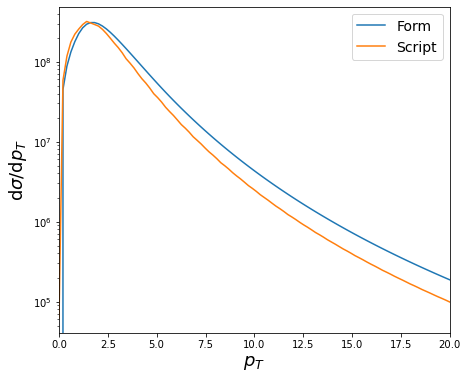

In [9]:
plt.figure(figsize=(7, 6))
plt.plot(df_form['pt'], df_form['central'], label='Form')
plt.plot(df_int_interp['pt'], df_int_interp['integral'], label='Script')

plt.xlabel(r'$p_T$', fontsize=18)
plt.ylabel(r'$\mathrm{d}\sigma/\mathrm{d}p_T$', fontsize=18)
plt.yscale("log")
plt.xlim(0,20)

plt.legend(fontsize=14)
plt.show()